In [1]:
using Random, Distributions, DataFrames, Turing, StatsPlots, Plots

## Bayesian designs for Turing library

┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/caesar/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/caesar/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/caesar/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/caesar/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/caesar/.julia/packages/AdvancedHMC/kB7Xa/s

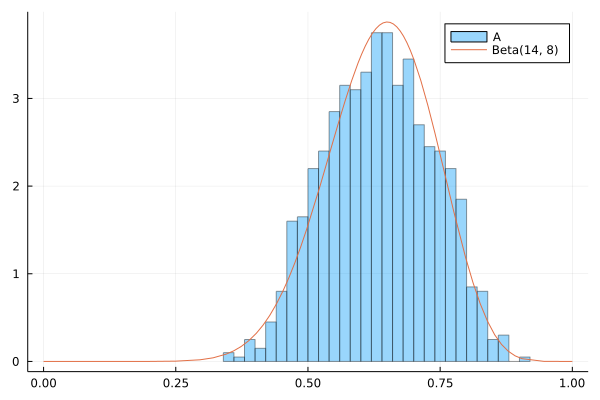

In [7]:
## This first macro is similar to that of the first tutorial

#=  Define a macro function for Turing.jl
    For how to use this model, please refer to the first tutorial of this course
    Inside this function, we define priors and sampling distributions 
=#

@model function binaryTrial(y::Vector{Int64}, n::Int64, a::Int64, b::Int64) 
    m ~ Beta(a, b)
    y[1] ~ Binomial(n, m)
end

## Simulate sampled data
# n = number of patients in a single arm
# p = TRUE probability of success rate given this treatment
N = 20
p = 0.6
d = Binomial(N, p)
## One trial
data = rand(d, 1)

## Complete the function by passing the data into it. Now the object "model" contains all model specifications
## a = 1, b = 1 for a flat prior
model = binaryTrial(data, N, 1, 1)

## Run MCMC
chain = sample(model, NUTS(), 1000)

## Plot posterior
histogram(chain[:m], bins=30, alpha=0.4, label="A", normalize = true) 
plot!(Beta(data[1] + 1, N - data[1] + 1), labels = "Beta($(data[1]+1), $(N - data[1] + 1))")

### Binary endpoint, subject level data      

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/caesar/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /Users/caesar/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/caesar/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/caesar/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/caesar/.julia/packages/AdvancedHMC/kB7Xa/s

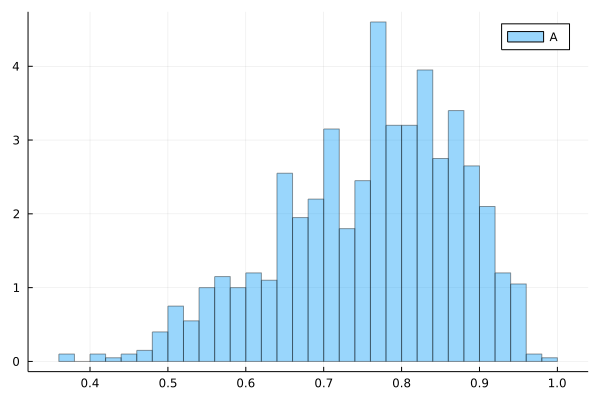

In [31]:
@model function binaryTrial(y::Vector{Int64}, a::Int64, b::Int64) 
    # Prior model for p
    p ~ Beta(a, b)
    
    n = size(y)[1]
    for i in 1:n 
        y[i] ~ Binomial(1, p)
    end  

end

## Simulate sampled data
# n = number of patients in a single arm
# p = TRUE probability of success rate given this treatment
N = 10
p = 0.6
d = Binomial(1, p)
## One trial as a vector of Bernoulli 0 and 1's
Random.seed!(5)
data = rand(d, N)

## Complete the function by passing the data into it. Now the object "model" contains all model specifications
## a = 1, b = 1 for a flat prior
model = binaryTrial(data, 1, 1)

## Run MCMC
chain = sample(model, NUTS(), 1000)

## Plot posterior
## With the seed we set, data has 8 success out of 10 data points, 
## so the posterior is heavy around 0.8
histogram(chain[:p], bins=30, alpha=0.4, label="A", normalize = true) 

### Continuous endpoint of Gaussian mixture model

In [5]:
# fieldnames(typeof(chain))
@model function continuousTrial(y::Vector{Float64}, a::Int64, b::Int64, K::Int64, ::Type{T} = Float64) where {T}
    n = size(y)[1]
    
    # Prior for population standard deviation, sigma
    S² ~ InverseGamma(a, b)
    
    mu_group_raw ~ filldist(Normal(0, sqrt(10)), K)
    
    ## ensure ordering to prevent label switching
    mu_group = sort(mu_group_raw)
    
    #lambda = Vector{T}(undef, K)
    #for i = 1:K
    #    lambda[i] ~ Dirichlet(ones(K)/K)
    #end
    lambda ~ Dirichlet(ones(K)/K)
    
    mu = Vector{Any}(undef, n)
    group = Vector{Any}(undef, n)
    for i in 1:n
        ## Categorical should be a vector p specifying prob for each category
        ## If an integer is specified, then they're given equal probs. 
        group[i] ~ Categorical(lambda)
        mu[i] = mu_group[group[i]]
        y[i] ~ Normal(mu[i], sqrt(S²))  
    end
    
end

## Assume two groups
K=2
## c(rnorm(500, 0, 1), rnorm(500, 5, 1)),
data = vcat(rand(Normal(0, 1), 10), rand(Normal(5, 1), 10))

## Complete the function by passing the data into it. Now the object "model" contains all model specifications
## a = 1, b = 1 for a flat prior
model = continuousTrial(data, 2, 3, K)

## Run MCMC
chain = sample(model, NUTS(), 200)

## Ordinal endpoints

### Time-to-event endpoint, blinded data

In [19]:
# fieldnames(typeof(chain))
@model function ordinalTrial(event::Vector{Int64}, time::Vector{Float64}, eta::Float64,
                                median_ctrl_lwd::Float64, median_ctrl_upd::Float64, ::Type{T} = Float64) where {T}
    n = size(event)[1]
    
    # Prior for hazard ratio
    hr ~ Uniform(hr_lbd, hr_upd)
    medianC ~ Uniform(median_ctrl_lwd, median_ctrl_upd)
    
    medianT = medianC / hr
    lambdaT = -log(1-0.5)/medianT
    lambdaC = log(2) / medianC
    
    for i in 1:n
        ## weibull likelihood for control arm
        like_ctrl[i] = exp(event[i] * (log(alpha) + alpha * log(lambdaC) + (alpha-1)*log(time[i])) - (lambdaC * time[i])^alpha)
        ## exponential likelihood for treatment arm
        like_trt[i] <- exp( -1 * time[i] * lambdaT + log(lambdaT) * event[i])

        ## definie log-likelihood using zero tricks
        phi[i] <- 100000 - log( eta*like_ctrl[i] + (1-eta)*like_trt[i] )
        zeros[i] ~ dpois(phi[i])
    end
    
end

## Assume two groups
K=2
## c(rnorm(500, 0, 1), rnorm(500, 5, 1)),

n = 400
rratio = 1
eta = rratio/(1+rratio)
## shape α=1 and unit scale
time = vcat(rand(Weibull(1,1), 198), rand(Exponential(1), 202))
event = rand(Binomial(1, 0.5), n)

## Complete the function by passing the data into it. Now the object "model" contains all model specifications
## a = 1, b = 1 for a flat prior
model = ordinalTrial(event, time, eta, 10.0, 40.0)

## Run MCMC
chain = sample(model, NUTS(100, 0.65), 200)

LoadError: UndefVarError: hr_lbd not defined

In [16]:
1:5

1:5

In [61]:
??NUTS

search: NUTS ANUTS DynamicNUTS ncodeunits InteractiveUtils



```
NUTS(n_adapts::Int, δ::Float64; max_depth::Int=5, Δ_max::Float64=1000.0, init_ϵ::Float64=0.0)
```

No-U-Turn Sampler (NUTS) sampler.

Usage:

```julia
NUTS()            # Use default NUTS configuration.
NUTS(1000, 0.65)  # Use 1000 adaption steps, and target accept ratio 0.65.
```

Arguments:

  * `n_adapts::Int` : The number of samples to use with adaptation.
  * `δ::Float64` : Target acceptance rate for dual averaging.
  * `max_depth::Int` : Maximum doubling tree depth.
  * `Δ_max::Float64` : Maximum divergence during doubling tree.
  * `init_ϵ::Float64` : Inital step size; 0 means automatically searching using a heuristic procedure.


In [5]:
Categorical(5)

Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.2, 0.2, 0.2, 0.2, 0.2]
)
